## **Implementation 1: Bitcoin Price Prediction using Deep Learning Techniques**

### **Importing Required Libraries**

In [1]:
import pandas as pd
import numpy as np
import datetime, pytz
from datetime import datetime, timedelta

from plotly import tools
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.offline as py

from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Bidirectional
from keras.layers import Activation, Dense, Dropout
from keras import callbacks
from keras import optimizers
from pandas import Series
import seaborn as sns
import math

In [3]:
from google.colab import drive
import os
import glob
drive.mount('/content/drive/', force_remount=True)
#os.chdir('/content/drive/My Drive/Data Analytics Assignment/Assignment/')
os.chdir("/content/drive/My Drive/")

Mounted at /content/drive/


### **Loading the Dataset**

In [5]:
bitcoin_file = 'Copy of bitcoinCryptoDataset.csv'

#bitcoin_file = 'Dataset/bitcoinCryptoDataset.csv'
bitcoin_df = pd.read_csv(bitcoin_file)

bitcoin_df.head(5)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### **Data Exploration**
In this section we will explore the Dataset and try to find insights from the data

In [10]:
bitcoin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4857377 entries, 0 to 4857376
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Timestamp          int64  
 1   Open               float64
 2   High               float64
 3   Low                float64
 4   Close              float64
 5   Volume_(BTC)       float64
 6   Volume_(Currency)  float64
 7   Weighted_Price     float64
dtypes: float64(7), int64(1)
memory usage: 296.5 MB


The timestamp present in the dataset is in "int" format and needs to be converted in Date-Time format in order to perform time series study.

In [11]:
# Converting the Timestamp column from string to datetime
bitcoin_df['Timestamp'] = [datetime.fromtimestamp(x) for x in bitcoin_df['Timestamp']]

In [12]:
bitcoin_df.head(5)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,2011-12-31 07:53:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-12-31 07:54:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-12-31 07:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011-12-31 07:56:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### **Visualising the Time Series data**

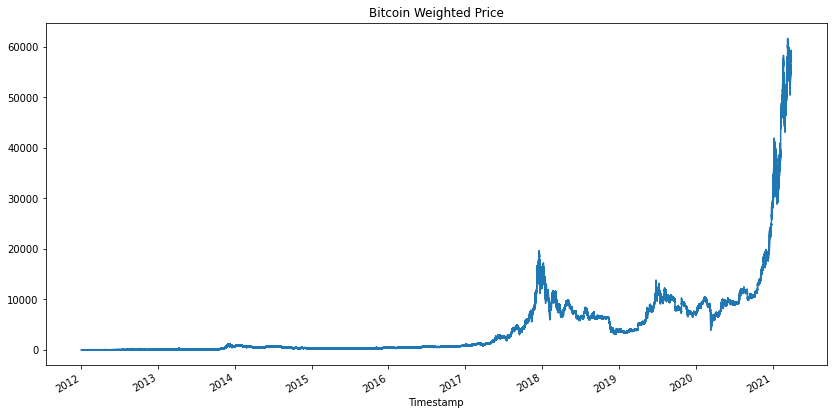

In [16]:
bitcoin_df.set_index("Timestamp").Weighted_Price.plot(figsize=(14,7), title="Bitcoin Weighted Price")

### **Handling Missing Values**

In [17]:
missing_values = bitcoin_df.isnull().sum()
missing_per = (missing_values/bitcoin_df.shape[0])*100
missing_table = pd.concat([missing_values,missing_per], axis=1, ignore_index=True) 
missing_table.rename(columns={0:'Total Missing Values',1:'Missing %'}, inplace=True)
missing_table

,Total Missing Values,Missing %
Timestamp,0,0.00000
Open,1243608,25.60246
High,1243608,25.60246
Low,1243608,25.60246
Close,1243608,25.60246
Volume_(BTC),1243608,25.60246
Volume_(Currency),1243608,25.60246
Weighted_Price,1243608,25.60246


The Dataset attributes like Open, High, Low, Close, Volume, Weighted Price are present in minute format which is scraped from **Binance API** and on close observation we observed that most of the missing values are from 2011-2017 where there was no trend in the data observed so we have handled missing data using **Forward fill** and **interpolate** method

In [18]:
### function to impute missing values using interpolation ###
bitcoin_df['Open'] = bitcoin_df['Open'].interpolate()
bitcoin_df['Close'] = bitcoin_df['Close'].interpolate()
bitcoin_df['Weighted_Price'] = bitcoin_df['Weighted_Price'].interpolate()

bitcoin_df['Volume_(BTC)'] = bitcoin_df['Volume_(BTC)'].interpolate()
bitcoin_df['Volume_(Currency)'] = bitcoin_df['Volume_(Currency)'].interpolate()
bitcoin_df['High'] = bitcoin_df['High'].interpolate()
bitcoin_df['Low'] = bitcoin_df['Low'].interpolate()


In [19]:
bitcoin_df.head(5)
print(bitcoin_df.isnull().sum())

Timestamp            0
Open                 0
High                 0
Low                  0
Close                0
Volume_(BTC)         0
Volume_(Currency)    0
Weighted_Price       0
dtype: int64


### **Exploratory Data Analysis**
No Null values in the final output. 

First, we will create a copy of the dataset as in the next step we will be setting index as our Timestamp column. Its main advatange is to be able to query the datset fast and also helps in quering and filtering the dataset. Also, a lot of plots require our dataset to be indexed.

In [20]:
#created a copy 
bitcoin_df_non_indexed = bitcoin_df.copy()

In [21]:
bitcoin_df = bitcoin_df.set_index('Timestamp')
bitcoin_df.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.39
2011-12-31 07:53:00,4.39,4.39,4.39,4.39,0.555046,2.436653,4.39
2011-12-31 07:54:00,4.39,4.39,4.39,4.39,0.654511,2.873305,4.39
2011-12-31 07:55:00,4.39,4.39,4.39,4.39,0.753977,3.309958,4.39
2011-12-31 07:56:00,4.39,4.39,4.39,4.39,0.853442,3.746611,4.39



**Visualizing the weighted price using markers** 

When dealing with time-series data, visualization can show a lot. Markers may be added to the storyline to help highlight particular observations or incidents in the time chain. Plotting line graph using **Weighted Price**

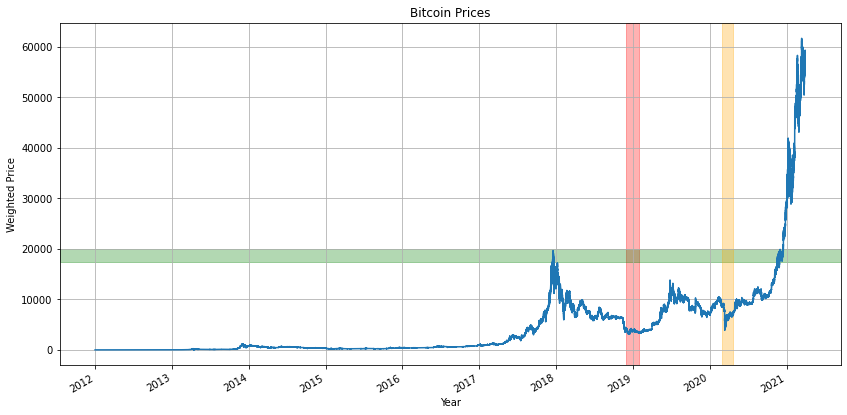

In [27]:
btc_trace_by_year = bitcoin_df['Weighted_Price'].plot(title='Bitcoin Prices', grid=True, figsize=(14,7))
btc_trace_by_year.set_xlabel('Year')
btc_trace_by_year.set_ylabel('Weighted Price')

btc_trace_by_year.axvspan('2018-12-01','2019-01-31',color='red', alpha=0.3)
btc_trace_by_year.axhspan(17500,20000, color='green',alpha=0.3)

btc_trace_by_year.axvspan('2020-03-01','2020-04-20',color='orange', alpha=0.3)

Plotting line graph using **Close Price**

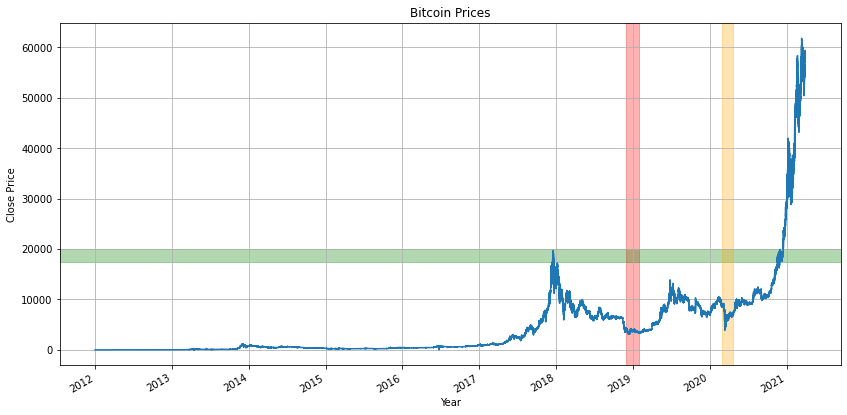

In [28]:
btc_trace_by_year = bitcoin_df['Close'].plot(title='Bitcoin Prices', grid=True, figsize=(14,7))
btc_trace_by_year.set_xlabel('Year')
btc_trace_by_year.set_ylabel('Close Price')

btc_trace_by_year.axvspan('2018-12-01','2019-01-31',color='red', alpha=0.3)
btc_trace_by_year.axhspan(17500,20000, color='green',alpha=0.3)

btc_trace_by_year.axvspan('2020-03-01','2020-04-20',color='orange', alpha=0.3)

We can see from above Line graph from year 2011- 2016 there was no such trend observed in data as Bitcoin didnt get much attention from the public domain. From year 2017 we can see slight Spike in data and since then an upward trend in the data was observed so we wil visualise data from the year 2017-2021

Text(0, 0.5, 'Weighted_Price')

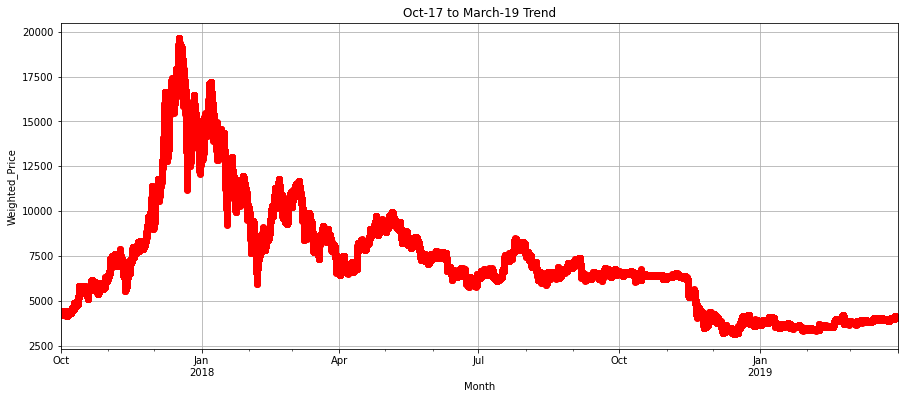

In [29]:
#Zooming in

btc_trace_2017_to_2019 = bitcoin_df.loc['2017-10':'2019-03','Weighted_Price'].plot(marker='o', linestyle='-',figsize=(15,6), title="Oct-17 to March-19 Trend", grid=True, color='red')
btc_trace_2017_to_2019.set_xlabel('Month')
btc_trace_2017_to_2019.set_ylabel('Weighted_Price')

 We will use Pandas to investigate it further in the coming sections.

Text(0, 0.5, 'Weighted_Price')

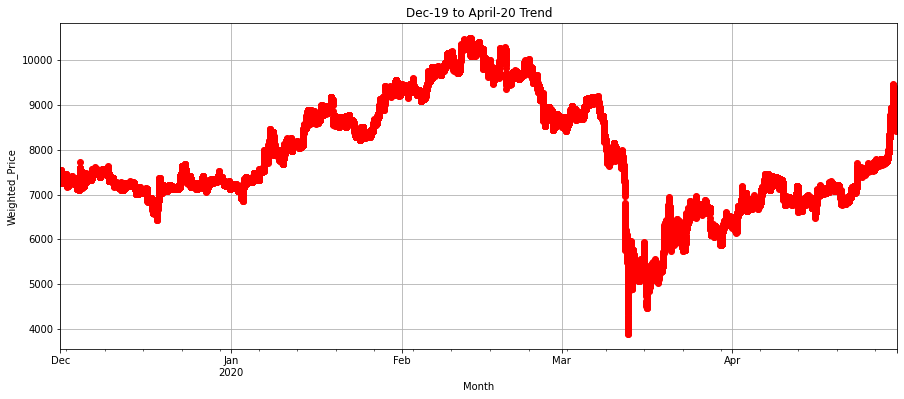

In [30]:
#Zooming in

btc_trace_2017_to_2019 = bitcoin_df.loc['2019-12':'2020-04','Weighted_Price'].plot(marker='o', linestyle='-',figsize=(15,6), title="Dec-19 to April-20 Trend", grid=True, color='red')
btc_trace_2017_to_2019.set_xlabel('Month')
btc_trace_2017_to_2019.set_ylabel('Weighted_Price')

Now we will build a heat map using correlation to see how various features are related to one another.

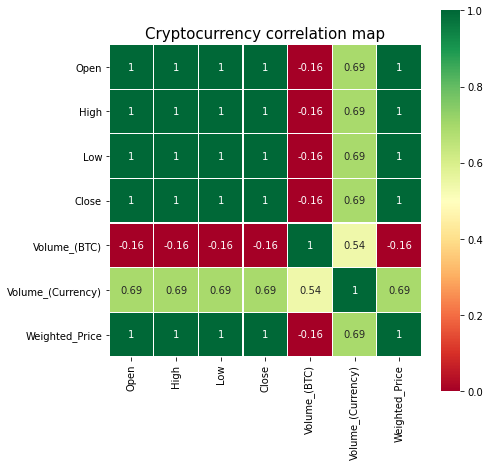

In [35]:
corrmat = bitcoin_df.corr(method='spearman')
fig, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(corrmat, vmax=1., square=True, annot=True, cmap='RdYlGn', linewidths=0.1, vmin=0)
plt.title("Cryptocurrency correlation map", fontsize=15)
plt.show()

**Observation:** Volume(Currency) is corrlerated to Weighted Price. Open, High, Low, Close are directly related to Weighted Price

#### **Time resampling**

To consolidate data into a given time frame, such as a month or quarter, we use a method called time resampling. We will then see a summary of bitcoin market patterns and make decisions based on them. We have consolidated minute data in hourly data to see a summary of pattern.

The **.resample()** method in the pandas library resamples certain time series results. The resample approach in pandas is similar to the groupby method in that it groups data based on a time range. This is how the resample() feature looks:

In [36]:
bitcoin_hourly_df = bitcoin_df.resample('1H').mean()
bitcoin_hourly_df = bitcoin_hourly_df.reset_index()

bitcoin_hourly_df.head(5)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2011-12-31 07:00:00,4.39,4.39,4.39,4.39,0.803709,3.528285,4.39
1,2011-12-31 08:00:00,4.39,4.39,4.39,4.39,4.185530,18.374477,4.39
2,2011-12-31 09:00:00,4.39,4.39,4.39,4.39,10.153449,44.573640,4.39
3,2011-12-31 10:00:00,4.39,4.39,4.39,4.39,16.121368,70.772803,4.39
4,2011-12-31 11:00:00,4.39,4.39,4.39,4.39,22.089286,96.971967,4.39


To summarize what we observed above:

bitcoin_df.resample() is used to resample the bitcoin price data.
The **‘1H’** stands for hourly frequency, and denotes the offset values by which we want to resample the data.
mean() indicates that we want the average bitcoin price during this period.
The offset values list can be found in the pandas [documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).

In [37]:
bitcoin_daily_df = bitcoin_df.resample("24H").mean() #daily resampling
bitcoin_daily_df.head(5)

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31,4.476415,4.478946,4.476415,4.478946,17.940426,79.495594,4.477370
2012-01-01,4.765576,4.765576,4.765576,4.765576,6.790640,32.971105,4.765576
2012-01-02,5.006549,5.006549,5.006549,5.006549,15.183373,75.932706,5.006549
2012-01-03,5.206530,5.206530,5.206530,5.206530,7.917041,40.795994,5.206530
2012-01-04,5.202511,5.241699,5.202511,5.241699,13.659736,72.860096,5.216680


We have created a new dataframe named **bitcoin_wp_df** to resample based on **'Close'** feature 

In [38]:
# Create daily df[Date, Close]

#bitcoin_wp_df = bitcoin_df.groupby('Date')['Close'].mean()
bitcoin_wp_df = bitcoin_df.resample("24H")['Close'].mean()
bitcoin_wp_df = pd.DataFrame(bitcoin_wp_df)
bitcoin_wp_df.shape

(3379, 1)

In [39]:
bitcoin_wp_df['Close'].fillna(method='ffill', inplace=True)

In [40]:
bitcoin_wp_df.isnull().sum()

Close    0
dtype: int64

### **Shift Data**
Before we begin constructing our model, we will first complete some essential steps. The first step is to move our outcome vector one timestep up (-1). The aim is to arrange our data so that the predictor variables can be used to forecast **Tommorrow_Close**, the next day's closing price.

In [42]:
bitcoin_wp_df['Tommorow_Close'] = bitcoin_wp_df['Close'].shift(-1,fill_value=0)
# drop last row because we shifted value (remember this when you add your forecasting data)
bitcoin_wp_df.drop(bitcoin_wp_df.tail(1).index,inplace=True) 

In [43]:
bitcoin_wp_df

,Close,Tommorow_Close
Timestamp,,
2011-12-31,4.478946,4.765576
2012-01-01,4.765576,5.006549
2012-01-02,5.006549,5.206530
2012-01-03,5.206530,5.241699
2012-01-04,5.241699,6.162639
...,...,...
2021-03-25,52126.334844,53242.805122
2021-03-26,53242.805122,55194.327465
2021-03-27,55194.327465,55835.628517


### **Splitting the Data into Train and Test Sets** (80 % for Training and 20 % for Testing)

In [49]:
# Split data into train (80%) and test (20%)
training_size = int(len(bitcoin_wp_df)*0.80)
training_dataset, testing_dataset = bitcoin_wp_df.iloc[:training_size],bitcoin_wp_df.iloc[training_size:]

### **Visualizing the Train - Test Split**

Dimension of train data:  (2701, 2)
Dimension of test data:  (676, 2)


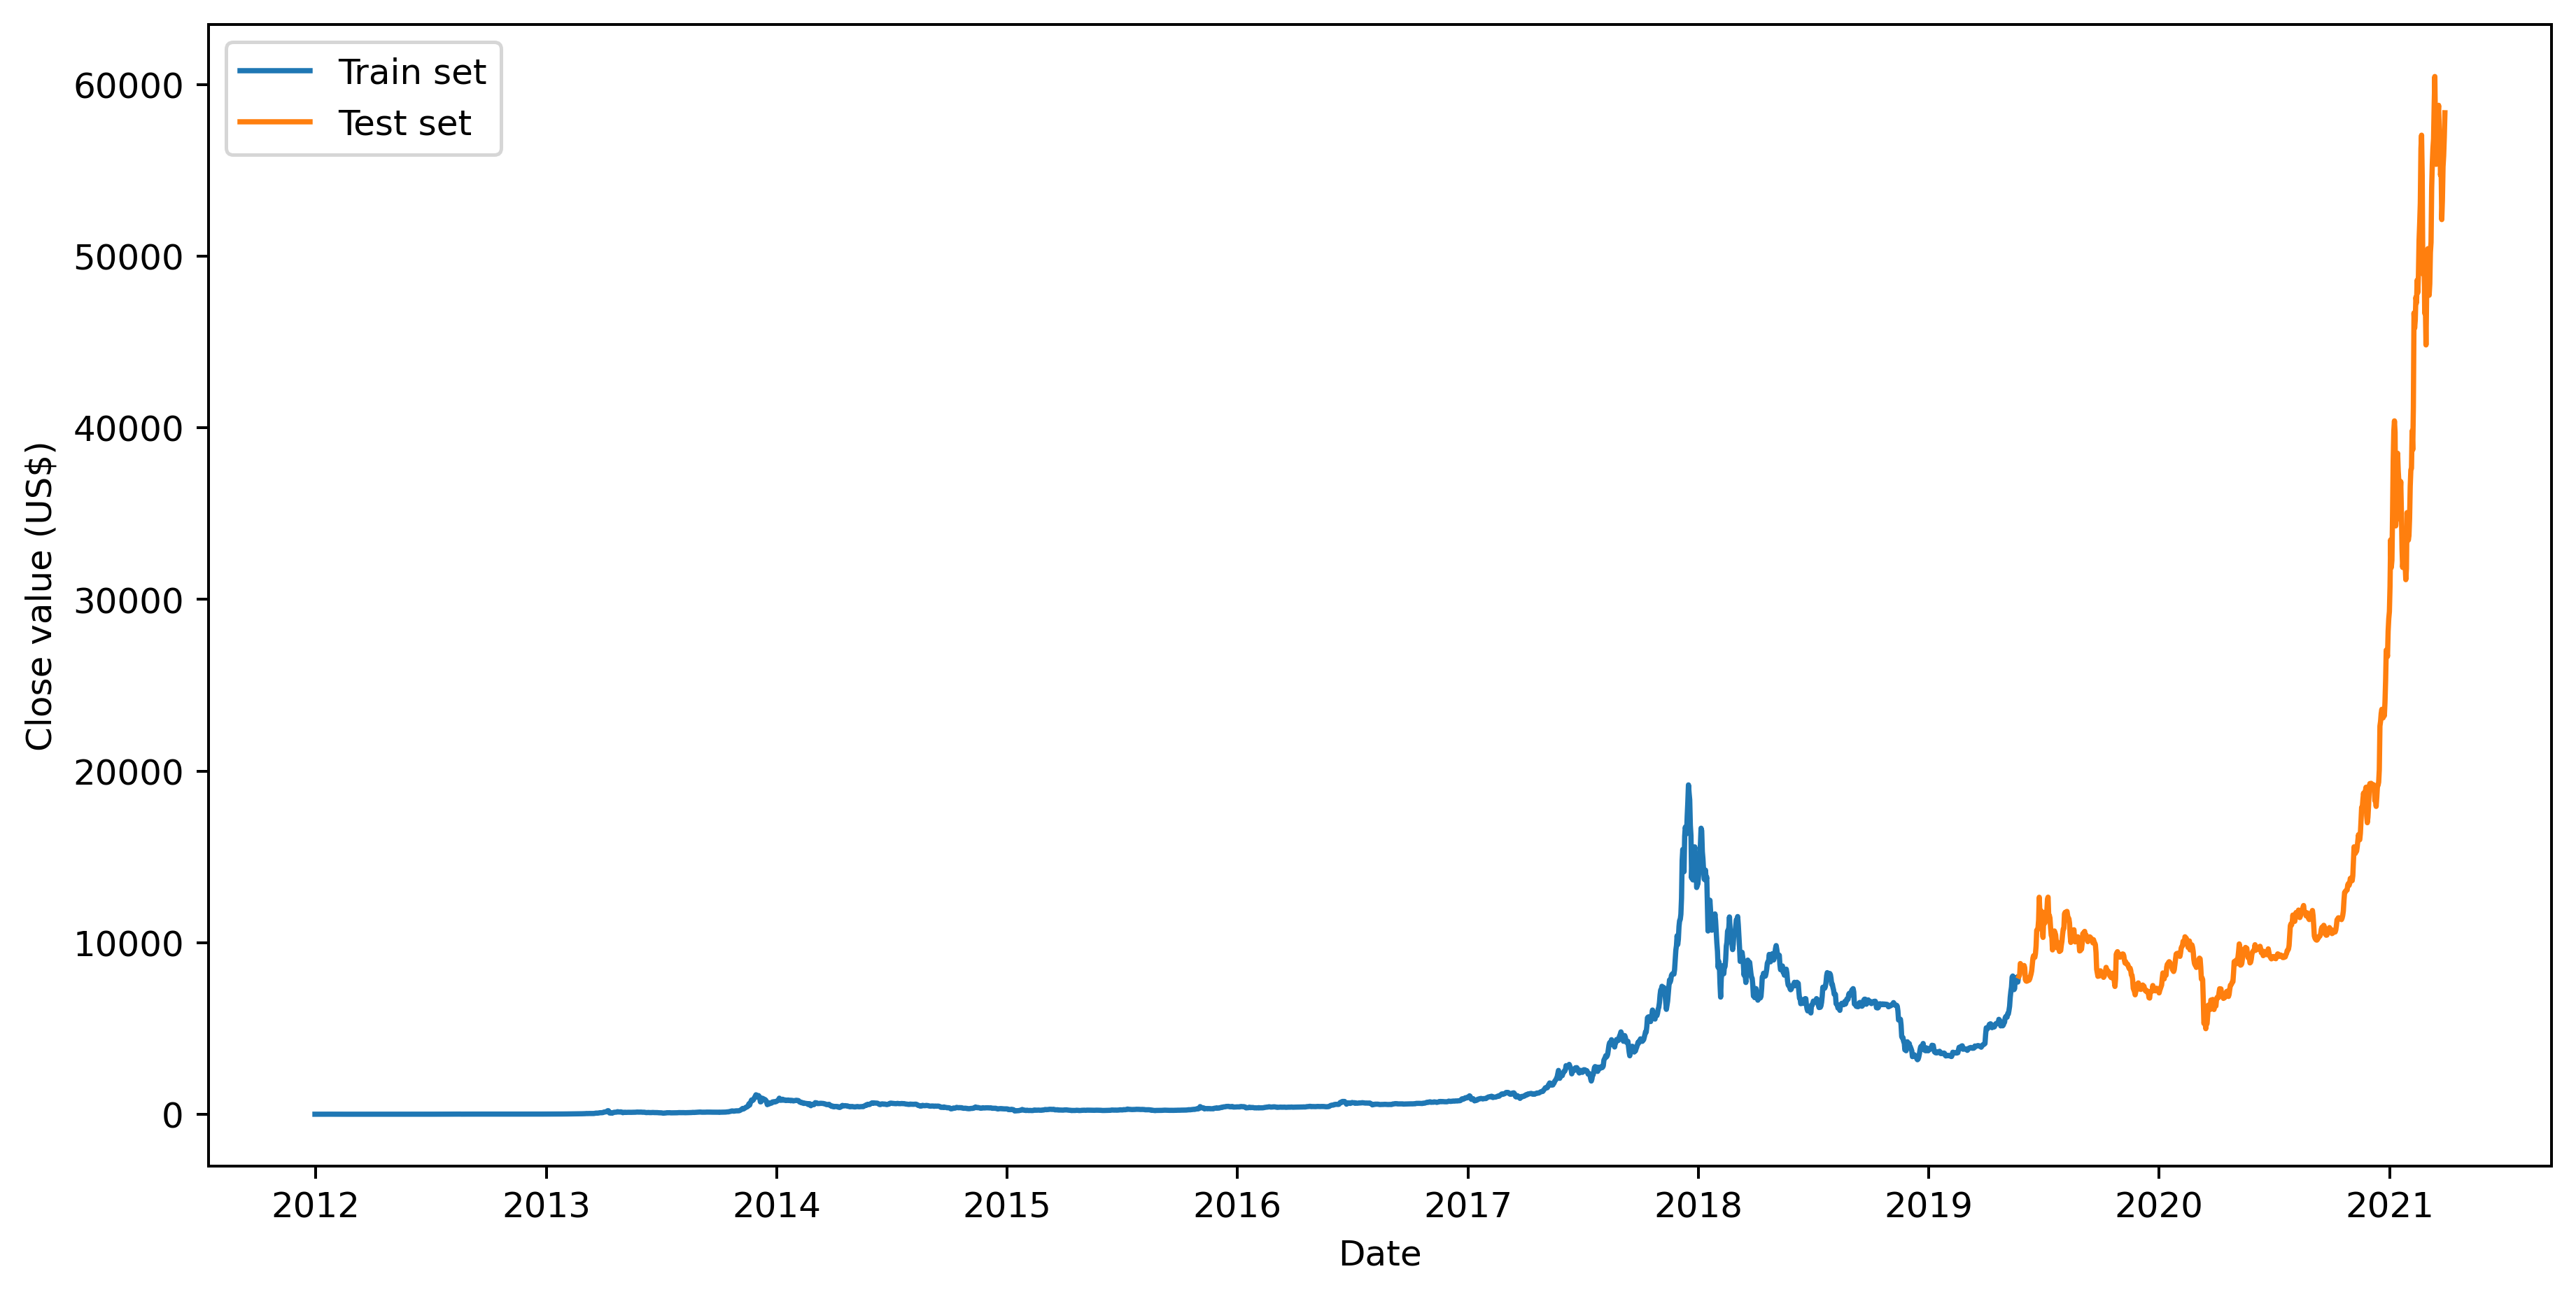

In [50]:
# Plot train and test data
plt.figure(figsize = (12, 6))
plt.rcParams['figure.dpi'] = 360
plt.plot(training_dataset.Tommorow_Close)
plt.plot(testing_dataset.Tommorow_Close)
plt.xlabel('Date')
plt.ylabel('Close value (US$)')
plt.legend(['Train set', 'Test set'], loc='upper left')
print('Dimension of train data: ',training_dataset.shape)
print('Dimension of test data: ', testing_dataset.shape)

In [51]:
# Split train data to X and y
X_train = training_dataset.drop('Tommorow_Close', axis = 1)
y_train = training_dataset.loc[:,['Tommorow_Close']]

# Split test data to X and y
X_test = testing_dataset.drop('Tommorow_Close', axis = 1)
y_test = testing_dataset.loc[:,['Tommorow_Close']]

### **Scaling the Dataset**
Scaling numeric variables to a given range is a good idea for many machine learning models. Hyperbolic tangent (tanh) function is the default activation function for these models, so we have scaled values to match this range. 
MinMinMaxScaler() function from sklearn is used to perform this.

Following steps are implemented which is a [good recommendaton](https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/).
<ol type ="a">
<li> Using the fit() function, we first fit the scaler to the training package.</li>
<li>Next, we use the transform() function to add the scale to the training set.</li>
<li>Last but not least, you add the scale to the test sample.</li>
</ol>
</ol>

In [54]:
# Different scaler for input and output
scaler_X = MinMaxScaler(feature_range = (-1,1))
scaler_Y = MinMaxScaler(feature_range = (-1,1))

# Fit the scaler using available training data
input_scaler = scaler_X.fit(X_train)
output_scaler = scaler_Y.fit(y_train)

# Apply the scaler to training data
train_y_scale = output_scaler.transform(y_train)
train_x_scale = input_scaler.transform(X_train)

# Apply the scaler to test data
test_y_scale = output_scaler.transform(y_test)
test_x_scale = input_scaler.transform(X_test)

### **Creating a three dimensional Data**

We have created a 3D data which has arguments like [batch, timestep, feature] as mentioned in Keras website. Function named **param_dataset** is used to reshape the data in required format as mentioned in Keras website [Link](https://keras.io/api/layers/recurrent_layers/lstm/).

The **Timestep** was set to 10, which ensures that the model will forecast **‘Tomorow Close’** based on the data from the previous ten days.

In [55]:
def param_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
        
    return np.array(Xs), np.array(ys)


Time_Steps = 10

X_test, y_test = param_dataset(test_x_scale, test_y_scale, Time_Steps)
X_train, y_train = param_dataset(train_x_scale, train_y_scale, Time_Steps)
print('X_train.shape: ', X_test.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_train.shape)

X_train.shape:  (666, 10, 1)
y_train.shape:  (2691, 1)
X_test.shape:  (666, 10, 1)
y_test.shape:  (2691, 1)


### **Building the Model for Training The Data**

Predicting using the state-of-the-art Deep learning Models
<ol type ="1">
<li>Long short-term memory (LSTM)</li>
<li>Bi-directional Long short-term memory (Bi-LSTM)</li>
<li>Gated recurrent units (GRUs)</li>
</ol>
</ol>


### **Create functions of each model mentioned above with parameters**
All of the models were made with simple two layers of 64 neurons each and a dense layer of one neuron. To avoid over-fitting, we added a 20% dropout rate. Finally, for these models, we used adam as the maximizing function and **mean square error** as the metric.

In [56]:
# Create BiLSTM model
def create_model_bilstm(units):
    model = Sequential()
    # First layer of BiLSTM
    model.add(Bidirectional(LSTM(units = units, return_sequences=True), 
                            input_shape=(X_train.shape[1], X_train.shape[2])))
    # Second layer of BiLSTM
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(1))
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model

# Create LSTM or GRU model
def create_model(units, m):
    model = Sequential()
    # First layer of LSTM
    model.add(m (units = units, return_sequences = True, 
                 input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Second layer of LSTM
    model.add(m (units = units))                 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model

# BiLSTM
model_bilstm = create_model_bilstm(64)

# GRU and LSTM 
model_gru = create_model(64, GRU)
model_lstm = create_model(64, LSTM)

### **Fitting Model on Train data**

In [57]:
# Fit BiLSTM, LSTM and GRU

def fit_model(model):
    early_stop = callbacks.EarlyStopping(monitor = 'val_loss',patience = 10)

    # Set shuffle equal to False due to importance of oder for this dataset
    history = model.fit(X_train, y_train, epochs = 50, validation_split = 0.2,
                    batch_size = 32, shuffle = False, callbacks = [early_stop])
    return history

history_bilstm = fit_model(model_bilstm)
history_lstm = fit_model(model_lstm)
history_gru = fit_model(model_gru)

Epoch 1/50
68/68 [==============================] - 11s 51ms/step - loss: 0.1331 - val_loss: 0.0141
Epoch 2/50
68/68 [==============================] - 2s 25ms/step - loss: 0.0052 - val_loss: 0.0116
Epoch 3/50
68/68 [==============================] - 2s 26ms/step - loss: 0.0037 - val_loss: 0.0103
Epoch 4/50
68/68 [==============================] - 2s 25ms/step - loss: 0.0026 - val_loss: 0.0108
Epoch 5/50
68/68 [==============================] - 2s 25ms/step - loss: 0.0013 - val_loss: 0.0125
Epoch 6/50
68/68 [==============================] - 2s 26ms/step - loss: 3.7162e-04 - val_loss: 0.0151
Epoch 7/50
68/68 [==============================] - 2s 25ms/step - loss: 7.2352e-05 - val_loss: 0.0172
Epoch 8/50
68/68 [==============================] - 2s 25ms/step - loss: 5.0303e-05 - val_loss: 0.0186
Epoch 9/50
68/68 [==============================] - 2s 26ms/step - loss: 1.2436e-04 - val_loss: 0.0196
Epoch 10/50
68/68 [==============================] - 2s 25ms/step - loss: 1.7283e-04 - val_l

### **Metrics Used**

In [60]:
from sklearn.metrics import r2_score

scoreBiLstm = r2_score(y_test,model_bilstm.predict(X_test))
scoreLstm = r2_score(y_test,model_lstm.predict(X_test))
scoreGru = r2_score(y_test,model_gru.predict(X_test))
print('BiLSTM: {:.4f}'.format(scoreBiLstm))
print('LSTM: {:.4f}'.format(scoreLstm))
print('GRU: {:.4f}'.format(scoreGru))

BiLSTM: 0.8964
LSTM: 0.8857
GRU: 0.9791


### **Now We Make Predictions on Test Data**

In [61]:
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler_Y.inverse_transform(prediction)
    return prediction

prediction_bilstm = prediction(model_bilstm)
prediction_lstm = prediction(model_lstm)
prediction_gru = prediction(model_gru)

### **Inverse Data for prediction**
We must use an inverse transform to return our outcome variable to its original form before we can make predictions on our results. Remember that the data are normalized to a range of -1 to 1. Our predictions would be inside this scaled range if we don't use an inverse function.

In [62]:
# Must inverse scaler_y to make predictions
y_test = scaler_Y.inverse_transform(y_test)
y_train = scaler_Y.inverse_transform(y_train)

### Visualise the Actual and Predicted Price

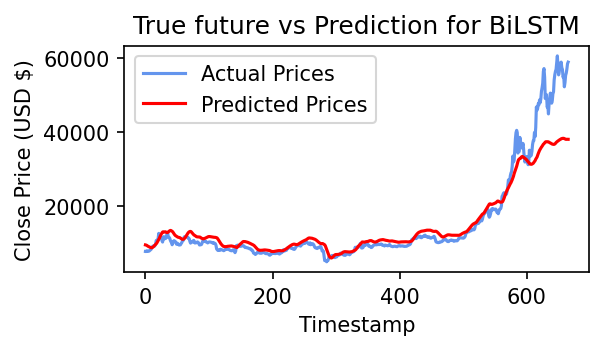

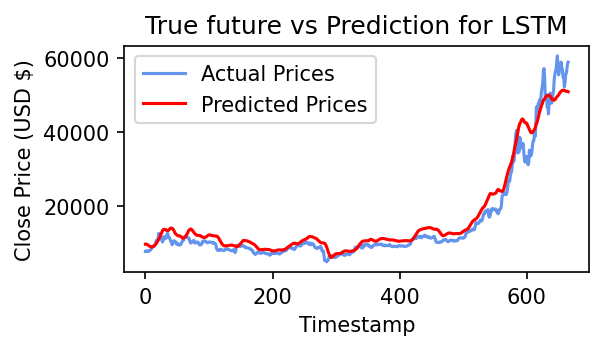

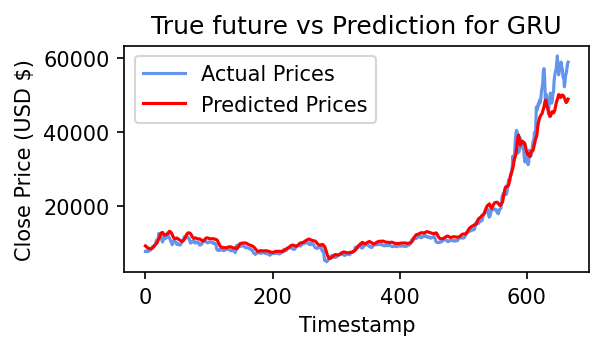

In [ ]:
def plot_future(prediction, model_name, y_test):
    plt.figure(figsize=(4, 2))
    plt.rcParams['figure.dpi'] = 150
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='Actual Prices', color='cornflowerblue')
    plt.plot(np.arange(range_future), np.array(prediction),label='Predicted Prices', color='red')

    plt.title('True future vs Prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Timestamp')
    plt.ylabel('Close Price (USD $)')
   
    
plot_future(prediction_bilstm, 'BiLSTM', y_test)
plot_future(prediction_lstm, 'LSTM', y_test)
plot_future(prediction_gru, 'GRU', y_test)

### Evaluation Metric Used

In [ ]:
# Define a function to calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()

    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')


evaluate_prediction(prediction_bilstm, y_test, 'Bidirectional LSTM')
evaluate_prediction(prediction_lstm, y_test, 'LSTM')
evaluate_prediction(prediction_gru, y_test, 'GRU')

Bidirectional LSTM:
Mean Absolute Error: 2462.0046
Root Mean Square Error: 4802.3857

LSTM:
Mean Absolute Error: 2075.6426
Root Mean Square Error: 2761.1699

GRU:
Mean Absolute Error: 1355.4706
Root Mean Square Error: 2216.9941



## **Implementation 2: Bitcoin Price Prediction using Sentimental Analysis**

### **Loading The Dataset**

In [ ]:
crypto_df = pd.read_csv('Dataset/BitcoinScraped.csv')
news_df = pd.read_csv('Dataset/Google News/Sentiment Analysis/google_news_final_cleaned_sentiment.csv')

In [ ]:
crypto_df.dtypes

Unnamed: 0             int64
Timestamp             object
Open                 float64
High                 float64
Low                  float64
Close                float64
Volume_(BTC)         float64
Volume_(Currency)    float64
Weighted_Price       float64
dtype: object

In [ ]:
crypto_df.head(5)

,Unnamed: 0,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,4202177,2020-01-01 00:01:00,7161.51,7161.51,7155.09,7161.20,3.776924,27047.304680,7161.198209
1,4202178,2020-01-01 00:02:00,7158.82,7158.82,7158.82,7158.82,0.029278,209.595359,7158.820000
2,4202179,2020-01-01 00:03:00,7158.82,7158.82,7156.90,7156.90,0.065819,471.156094,7158.321885
3,4202180,2020-01-01 00:04:00,7158.50,7158.50,7154.97,7157.20,0.971387,6950.500833,7155.235666
4,4202181,2020-01-01 00:05:00,7156.52,7159.51,7150.10,7158.50,0.886932,6342.850841,7151.454018


## Convert Timestamp Data to Date-time format and setting it as Index

In [ ]:
crypto_df = crypto_df.drop('Unnamed: 0', axis = 1)
crypto_df['Timestamp'] = pd.to_datetime(crypto_df['Timestamp'])
crypto_df = crypto_df.set_index('Timestamp')
crypto_df = crypto_df.resample("24H").mean() #daily resampling

In [ ]:
crypto_df.head(5)

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2020-01-01,7195.538631,7197.844309,7193.498749,7195.470598,0.773876,5568.365842,6970.811013
2020-01-02,7072.455618,7075.328819,7069.454750,7072.435687,2.758825,19395.123812,7018.451763
2020-01-03,7217.384382,7221.743132,7213.313340,7217.607403,5.606062,40532.870021,7182.953168
2020-01-04,7321.584264,7324.243160,7318.929382,7321.510688,2.261623,16545.442802,7108.363486
2020-01-05,7429.948701,7432.644646,7427.346167,7429.768535,1.880051,13964.210748,7280.394717


In [ ]:
news_df.tail(5)

,Unnamed: 0,googleNewsFlair,googleNewsPolarity,googleNewsSubjectivity,googleNewsPositive,googleNewsNegative,googleNewsNeutral,googleNewsCompound
451,2021-03-27,-0.246625,0.095357,0.388912,0.093125,0.036750,0.869875,0.766975
452,2021-03-28,-0.215313,0.126682,0.324371,0.103000,0.021250,0.875875,0.702937
453,2021-03-29,-0.723400,0.221786,0.477090,0.119750,0.019625,0.860500,0.910150
454,2021-03-30,-0.768513,0.080451,0.404250,0.099750,0.028875,0.871500,0.937550
455,2021-03-31,-0.863350,0.106647,0.423917,0.105875,0.020500,0.873625,0.968025


In [ ]:
news_df.rename(columns = {'Unnamed: 0':'Timestamp'}, inplace = True)

In [ ]:
news_df.drop(news_df.tail(1).index,inplace=True) 

In [ ]:
news_df['Timestamp'] = pd.to_datetime(news_df['Timestamp'])
news_df = news_df.set_index('Timestamp')

### Merging the Bitcoin Price Data along with scraped News data from([Google news](https://news.google.com/search?q=bitcoin&hl=en-IE&gl=IE&ceid=IE%3Aen))

In [ ]:
result = pd.concat([crypto_df, news_df], axis=1) 

In [ ]:
result.head(5)

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,googleNewsFlair,googleNewsPolarity,googleNewsSubjectivity,googleNewsPositive,googleNewsNegative,googleNewsNeutral,googleNewsCompound
Timestamp,,,,,,,,,,,,,,
2020-01-01,7195.538631,7197.844309,7193.498749,7195.470598,0.773876,5568.365842,6970.811013,-0.912450,0.097719,0.382244,0.096250,0.039000,0.865000,0.978350
2020-01-02,7072.455618,7075.328819,7069.454750,7072.435687,2.758825,19395.123812,7018.451763,-0.390463,0.112038,0.387827,0.094000,0.038000,0.867625,0.921575
2020-01-03,7217.384382,7221.743132,7213.313340,7217.607403,5.606062,40532.870021,7182.953168,-0.753800,0.099566,0.431253,0.087375,0.041250,0.871500,0.882387
2020-01-04,7321.584264,7324.243160,7318.929382,7321.510688,2.261623,16545.442802,7108.363486,-0.310513,0.090471,0.462744,0.109000,0.046375,0.844375,0.640225
2020-01-05,7429.948701,7432.644646,7427.346167,7429.768535,1.880051,13964.210748,7280.394717,-0.510025,0.122651,0.437880,0.091375,0.036750,0.871500,0.774400


### **Scaling the Dataset like we did in Section .....**

In [ ]:
dataset = crypto_df.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
#print('dataset.shape', dataset.shape)
num_of_features = len(crypto_df.columns)

### **Configuring the parameters**

In [ ]:
expr_name = 'expr_1'
look_back = 60
lstm_layers = 32
epochs=5
batch_size=128

### **Splitting the Dataset into Train and Test**

In [ ]:
train_size_percent = 0.80
pred_col = result.columns.get_loc('Close')

# function to split the data
def create_dataset(dataset, pred_col, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), :]
    dataX.append(a)
    dataY.append(dataset[i + look_back, pred_col])
  return np.array(dataX), np.array(dataY)


train_size = int(len(dataset) * train_size_percent)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

trainX, trainY = create_dataset(train, pred_col, look_back=look_back)
testX, testY = create_dataset(test, pred_col, look_back=look_back)
# reshape input to be  [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], look_back, num_of_features))
testX = np.reshape(testX, (testX.shape[0],look_back, num_of_features))

print('Training dataset length ', len(train))
print('Testing dataset length ', len(test))
print('look_back ', look_back)

Training dataset length  364
Testing dataset length  91
look_back  60


### **Fitting The Model**

In [ ]:
# create and fit the LSTM network

model1 = Sequential()
model1.add(GRU(lstm_layers, input_shape=(trainX.shape[1],trainX.shape[2])))
model1.add(Dense(1))
model1.compile(loss='mean_squared_error', optimizer='adam')
history1= model1.fit(trainX, trainY,validation_split=0.2, epochs=epochs, batch_size=batch_size,shuffle=False)

Epoch 1/5
2/2 [==============================] - 2s 434ms/step - loss: 0.0127 - val_loss: 0.1015
Epoch 2/5
2/2 [==============================] - 0s 65ms/step - loss: 0.0053 - val_loss: 0.0631
Epoch 3/5
2/2 [==============================] - 0s 76ms/step - loss: 0.0024 - val_loss: 0.0372
Epoch 4/5
2/2 [==============================] - 0s 74ms/step - loss: 0.0026 - val_loss: 0.0224
Epoch 5/5
2/2 [==============================] - 0s 82ms/step - loss: 0.0042 - val_loss: 0.0156


## **Making Predictions on Test Data**

In [ ]:
trainPredict = model1.predict(trainX)
testPredict = model1.predict(testX)

In [ ]:
# Get something which has as many features as dataset
trainPredict_extended = np.zeros((len(trainPredict),num_of_features))
# Put the predictions there
trainPredict_extended[:,pred_col] = trainPredict[:,0]
# Inverse transform it and select the 3rd column.
trainPredict = scaler.inverse_transform(trainPredict_extended) [:,pred_col]

# Get something which has as many features as dataset
testPredict_extended = np.zeros((len(testPredict),num_of_features))
# Put the predictions there
testPredict_extended[:,pred_col] = testPredict[:,0]
# Inverse transform it and select the pred_col column.
testPredict = scaler.inverse_transform(testPredict_extended)[:,pred_col] 

trainY_extended = np.zeros((len(trainY),num_of_features))
trainY_extended[:,pred_col]=trainY
trainY = scaler.inverse_transform(trainY_extended)[:,pred_col]

testY_extended = np.zeros((len(testY),num_of_features))
testY_extended[:,pred_col]=testY
testY = scaler.inverse_transform(testY_extended)[:,pred_col]

# calculate root mean squared error
trainScore_RMSE = math.sqrt(mean_squared_error(trainY, trainPredict))
testScore_RMSE = math.sqrt(mean_squared_error(testY, testPredict))

# calculate absolute mean error
trainScore_MAE = np.sum(np.absolute(trainY - trainPredict))/len(trainY)
testScore_MAE = np.sum(np.absolute(testY - testPredict))/len(testY)

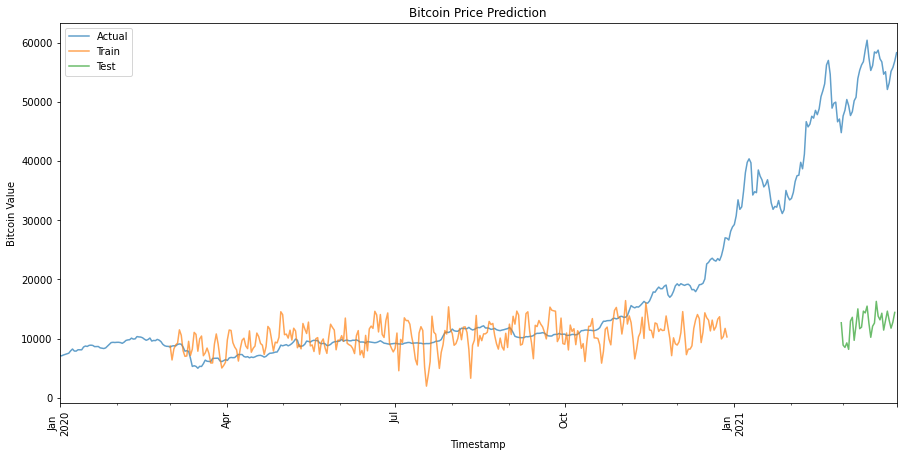

In [ ]:

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, pred_col] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, pred_col] = testPredict

# contruct pandas dataframe for plotting
time_df = pd.DataFrame(result.index)
time_df['Actual'] = scaler.inverse_transform(dataset)[:,pred_col]
df1 = pd.DataFrame(trainPredictPlot[:,pred_col],columns=['Train'])
df2 = pd.DataFrame(testPredictPlot[:,pred_col],columns=['Test'])
time_df2 = pd.concat([time_df, df1, df2], axis=1, sort=False)
time_df2.set_index('Timestamp',inplace=True)

# plot the output
fig, ax = plt.subplots(figsize=(15,7))
time_df2.plot(ax=ax,rot=90,alpha=0.7)
plt.xlabel('Timestamp')
plt.ylabel('Bitcoin Value')
plt.title('Bitcoin Price Prediction')
plt.savefig(expr_name + '.png',bbox_inches = "tight")

In [ ]:
print('-' * 50)
print('Experiment name:', expr_name)

print('-' * 50)
print('look_back days:', look_back)
print('lstm_layers:', lstm_layers)
print('epochs:', epochs)
print('batch_size:', batch_size)
print('dataset features', list(result.columns))


print('-' * 50)
print('Train Score: %.2f RMSE' % (trainScore_RMSE))
print('Test Score: %.2f RMSE' % (testScore_RMSE))

print('-' * 50)
print('Train Score: %.2f MAE' % (trainScore_MAE))
print('Test Score: %.2f MAE' % (testScore_MAE))

print('-' * 50)
print('Model summary:')
model1.summary()

--------------------------------------------------
Experiment name: expr_1
--------------------------------------------------
look_back days: 60
lstm_layers: 32
epochs: 5
batch_size: 128
dataset features ['Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price', 'googleNewsFlair', 'googleNewsPolarity', 'googleNewsSubjectivity', 'googleNewsPositive', 'googleNewsNegative', 'googleNewsNeutral', 'googleNewsCompound']
--------------------------------------------------
Train Score: 3898.56 RMSE
Test Score: 41725.22 RMSE
--------------------------------------------------
Train Score: 2899.59 MAE
Test Score: 41546.21 MAE
--------------------------------------------------
Model summary:
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 32)                6016      
________________________________________________________________

## **Conclusion:**



<ul>
<li>When we see the visualisation graphs of both the actual and predicted values from the LSTM and BiLSTM we can see that it predicted well until there was a sharp rise in the data at the end.</li>
<li>The GRU model, on the other hand, seems to be the most well-fitting in general. It seems to be better at tracking the patterns present in the data, even though it does not closely follow the true data.</li>
<li>GRU model could predict the trend in data whether there would be an upward or downward trend instead of predicting actual prices.</li>
<li>Results of Sentiment Analysis shows that it is less effective in forecasting the future Trend.</li>
</ol>
</ol>

 



